Manifold Analysis (Loading from .log files)
[Data Load] '/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET' 폴더에서 데이터 로딩 중 (Sensor: Arm Acc/Gyro)...
  -> Loaded mHealth_subject1.log: 35174 samples (ID 0 excluded)
  -> Loaded mHealth_subject2.log: 35532 samples (ID 0 excluded)
  -> Loaded mHealth_subject3.log: 35380 samples (ID 0 excluded)
  -> Loaded mHealth_subject4.log: 35328 samples (ID 0 excluded)
  -> Loaded mHealth_subject5.log: 33947 samples (ID 0 excluded)
  -> Loaded mHealth_subject6.log: 32205 samples (ID 0 excluded)
  -> Loaded mHealth_subject7.log: 34253 samples (ID 0 excluded)
  -> Loaded mHealth_subject8.log: 33332 samples (ID 0 excluded)
  -> Loaded mHealth_subject9.log: 34354 samples (ID 0 excluded)
  -> Loaded mHealth_subject10.log: 33690 samples (ID 0 excluded)

--- NEW ACTIVITY MAP ---
Activity 1: Standing
Activity 2: Sitting
Activity 3: Lying
Activity 4: Walking
Activity 5: Climbing stairs
Activity 6: Waist bends
Activity 7: Knees bending
Activity 8: Cyc

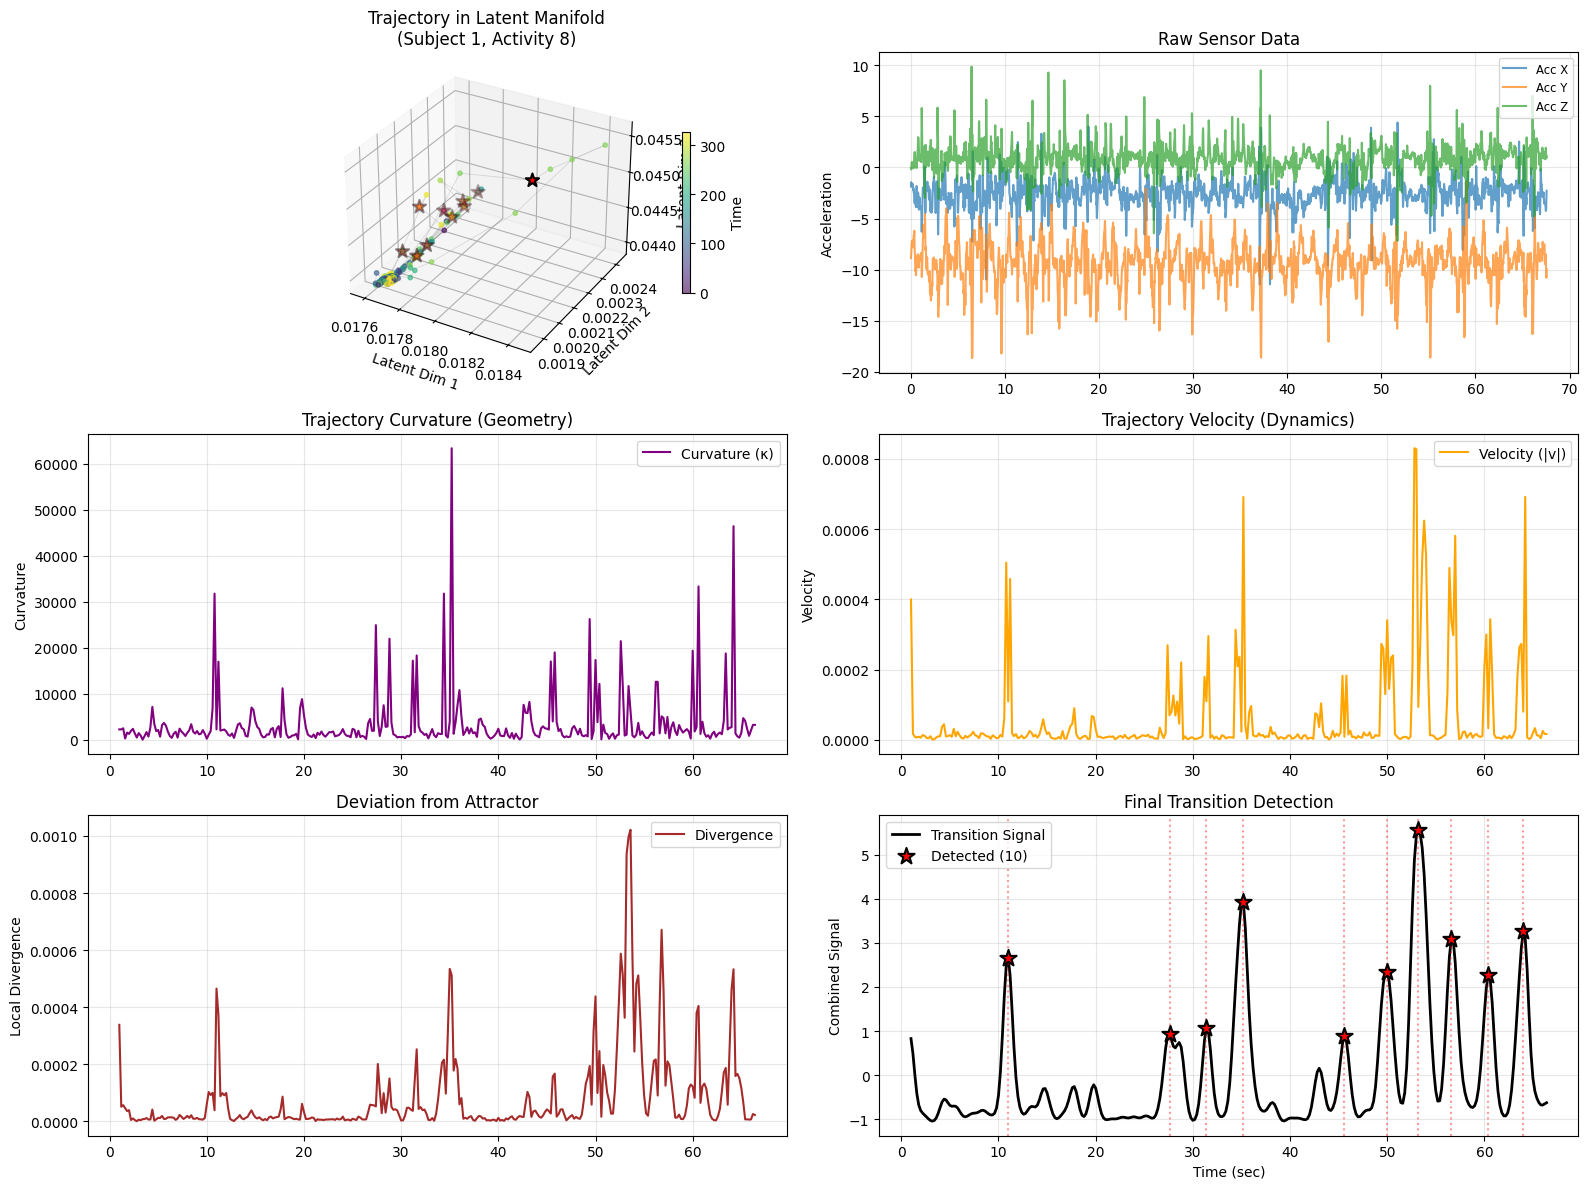

Subject 2 | Activity 8 | Detected Transitions: 17


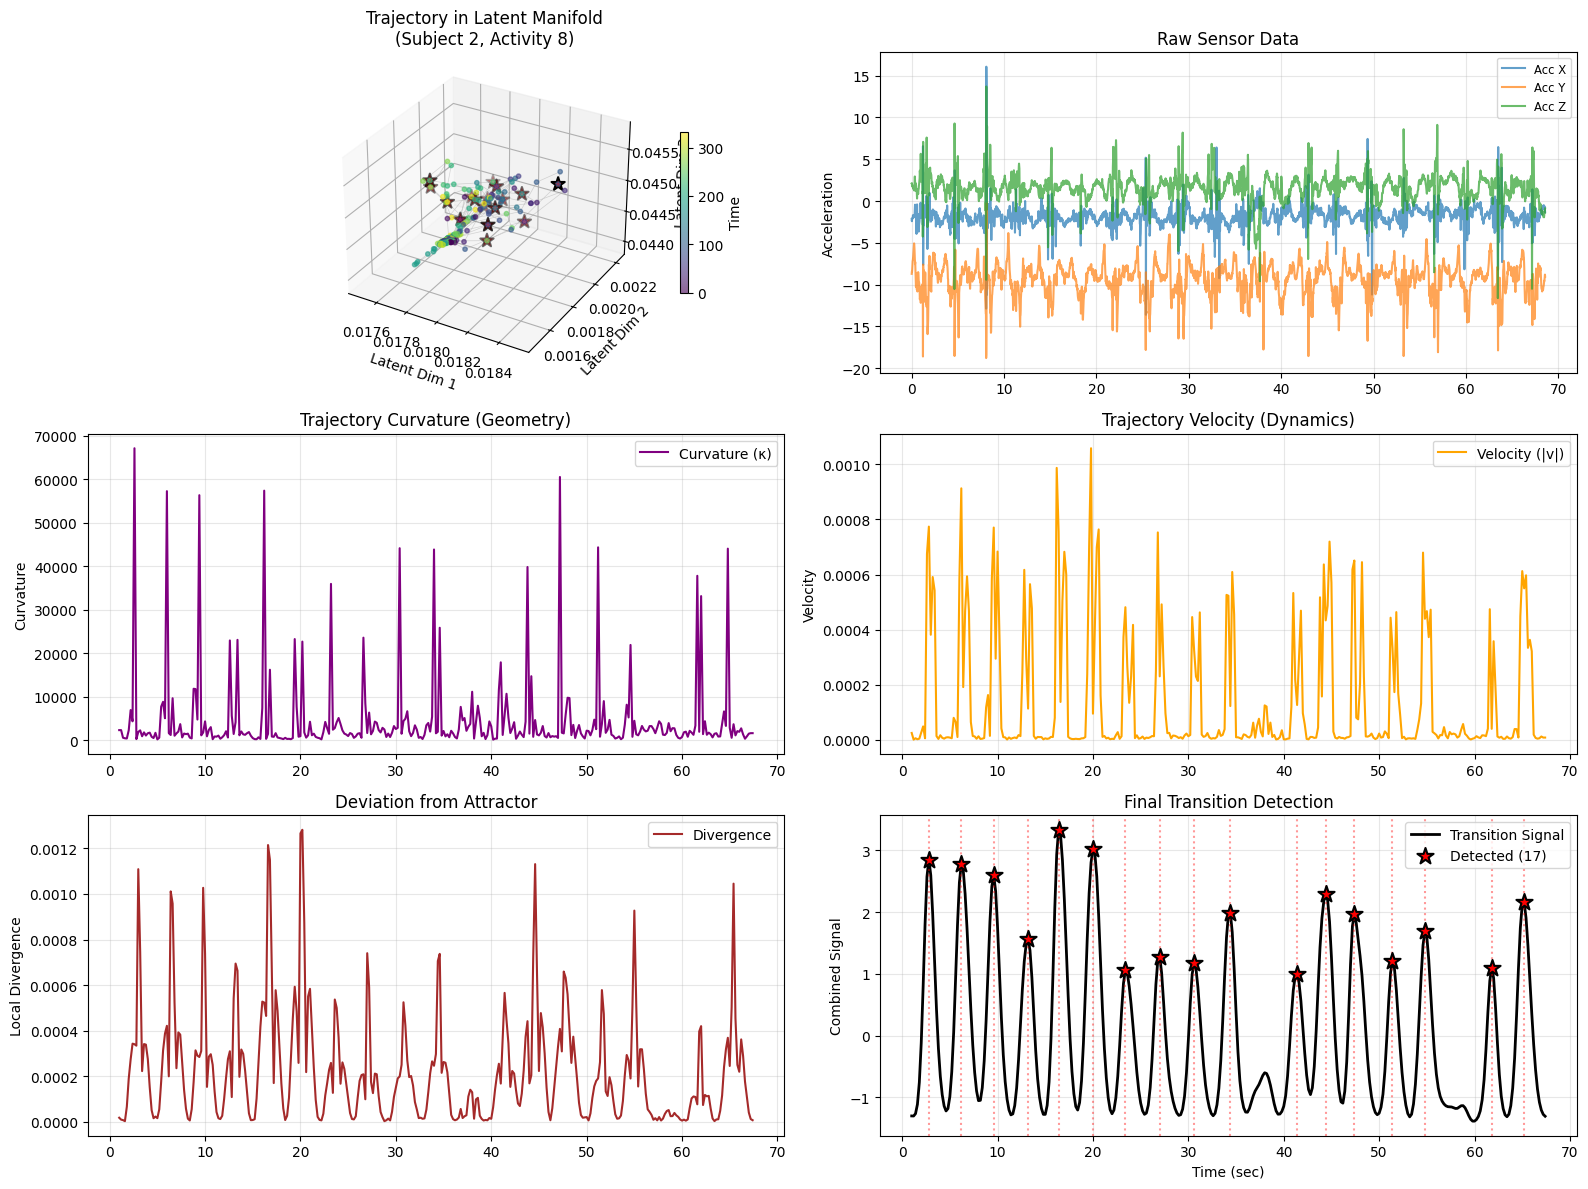

Subject 3 | Activity 8 | Detected Transitions: 11


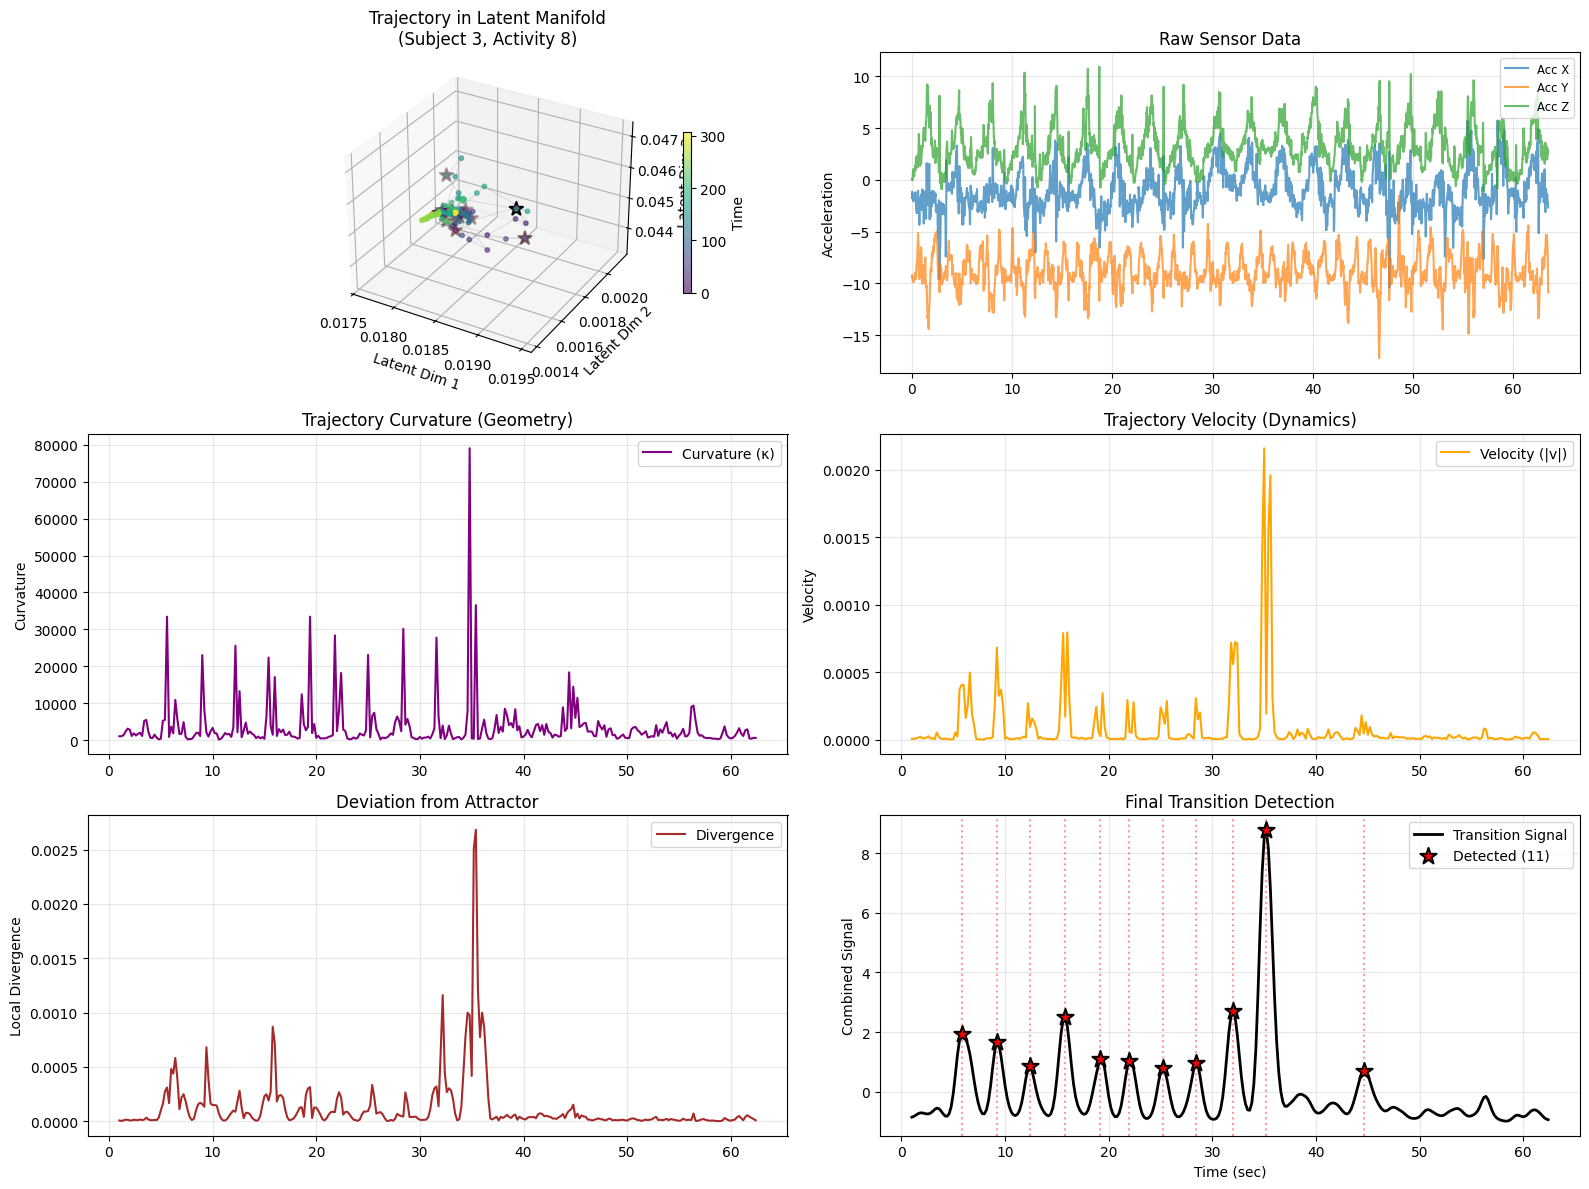

Subject 4 | Activity 8 | Detected Transitions: 11


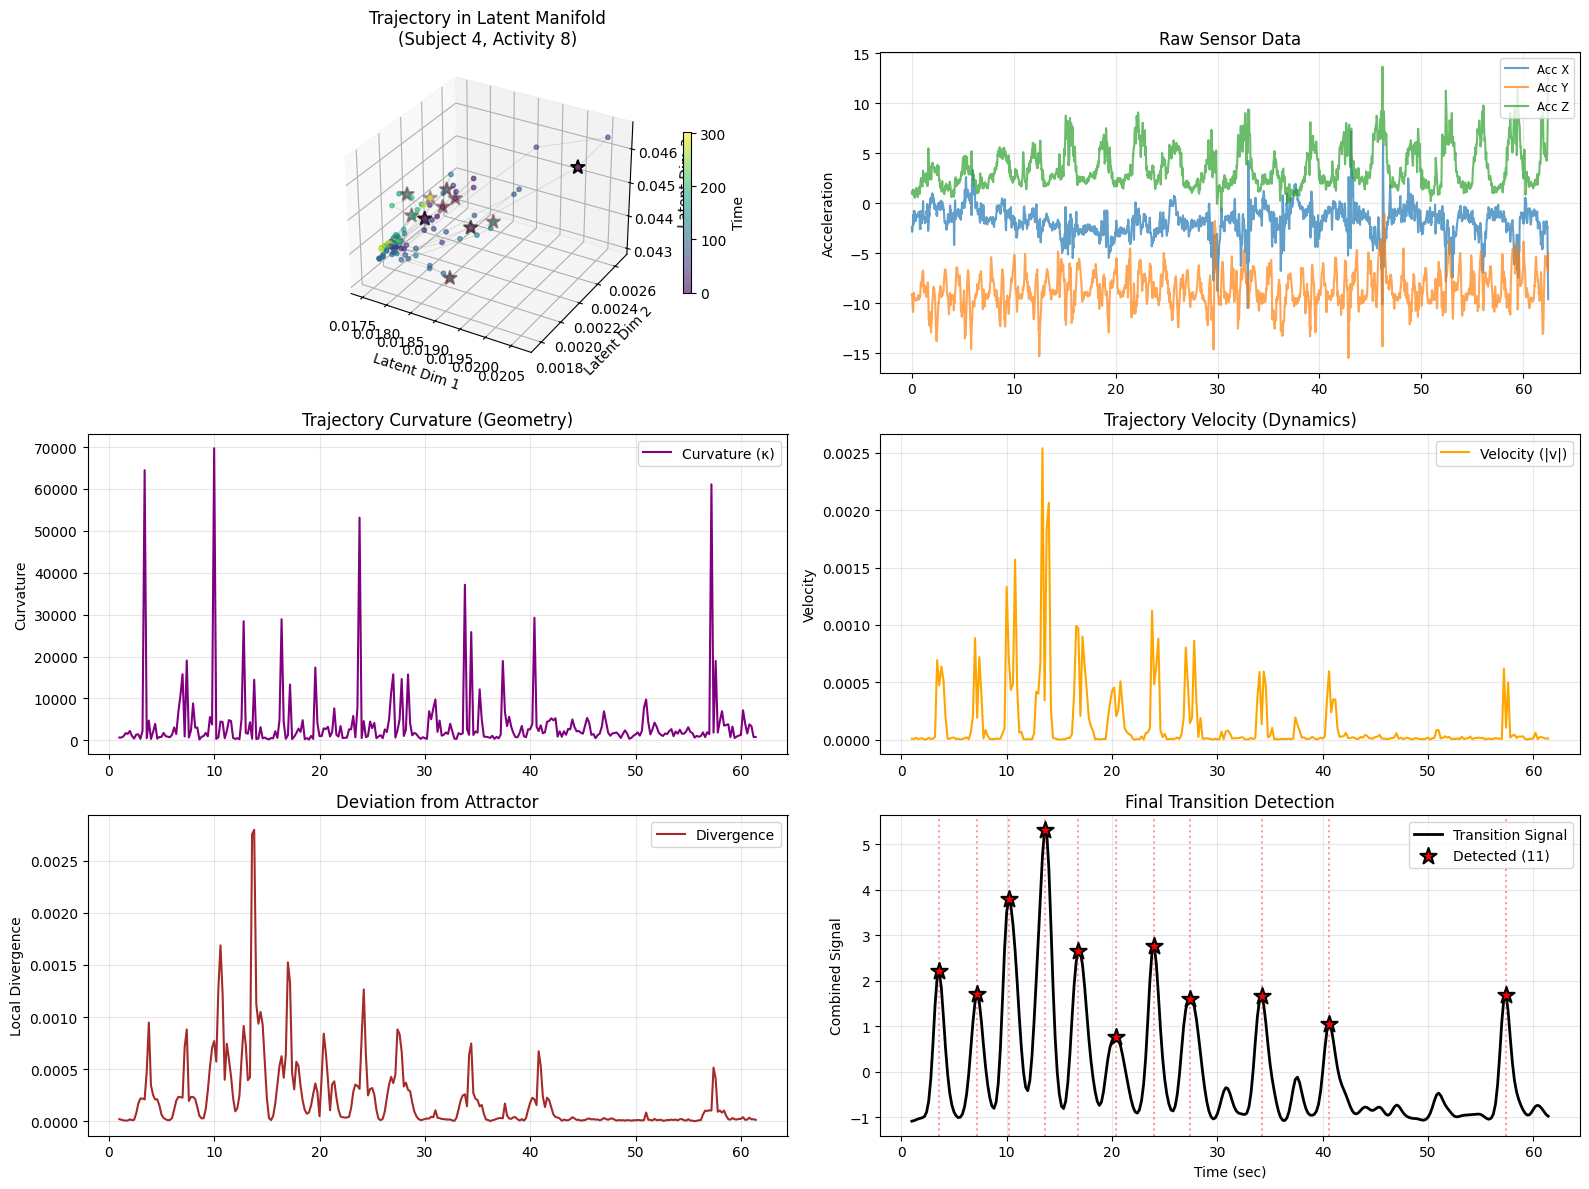

Subject 5 | Activity 8 | Detected Transitions: 11


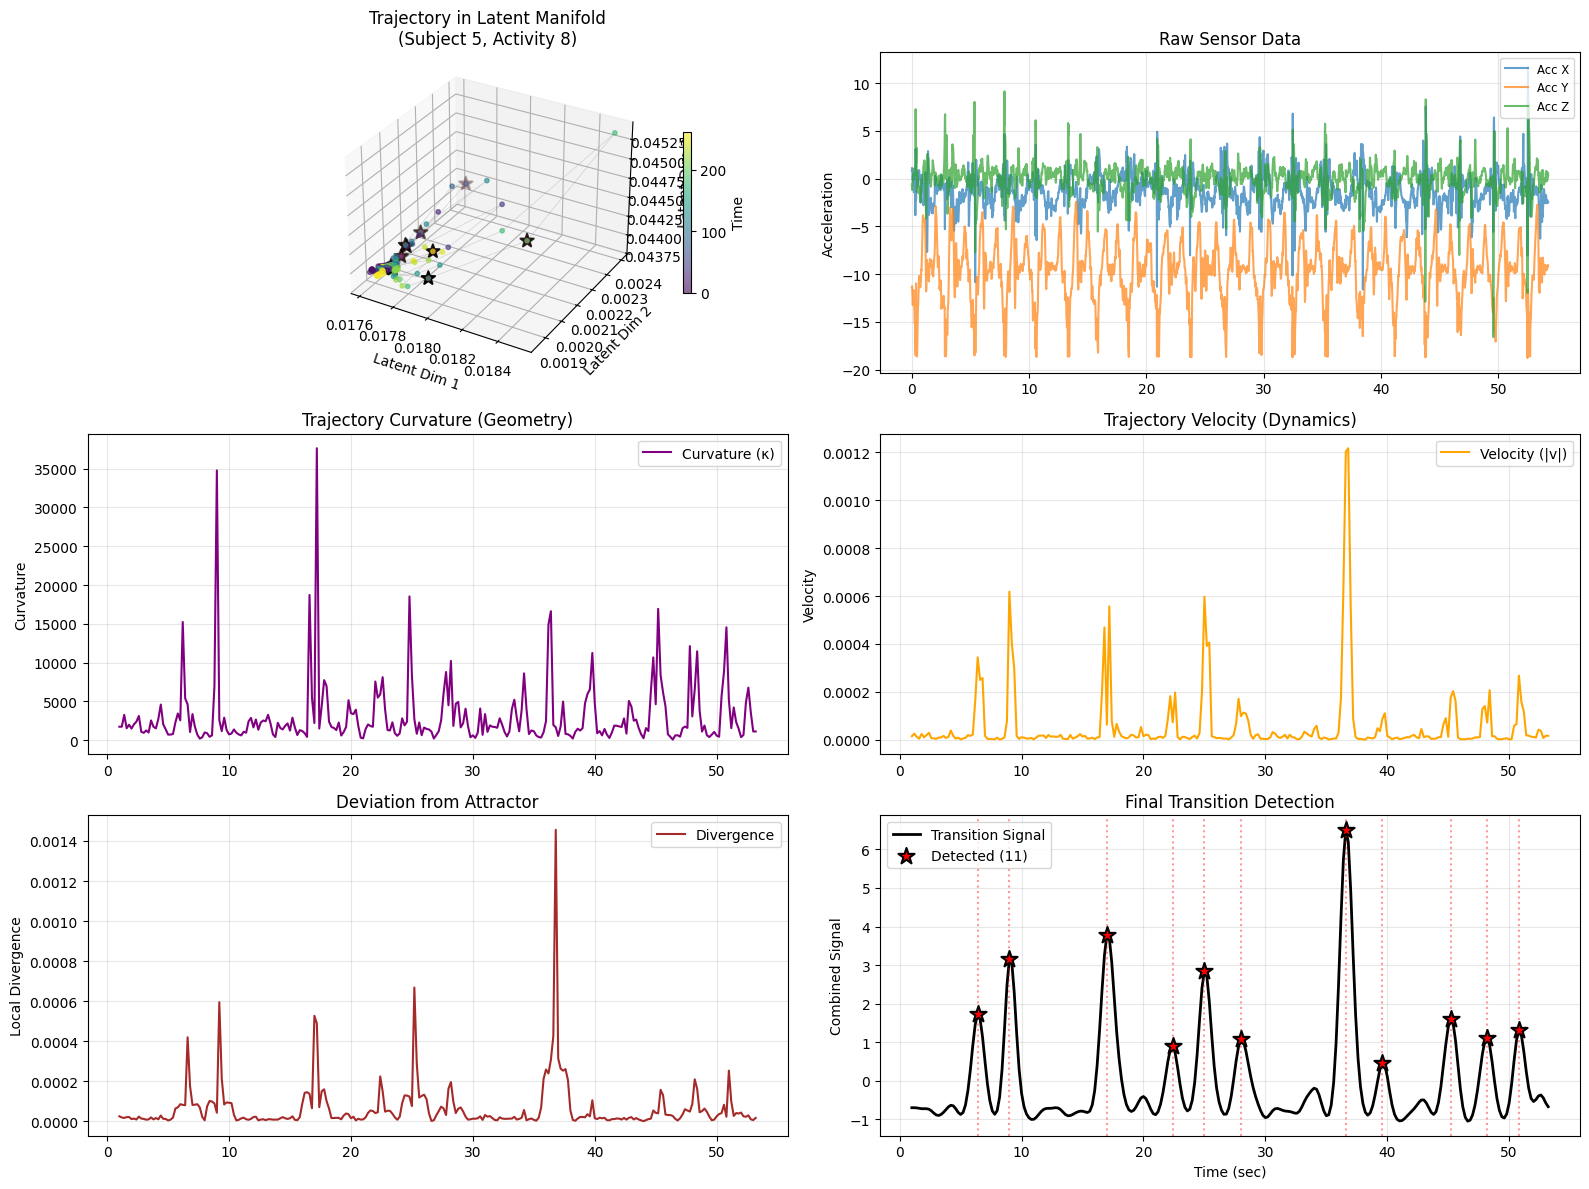

Subject 6 | Activity 8 | Detected Transitions: 6


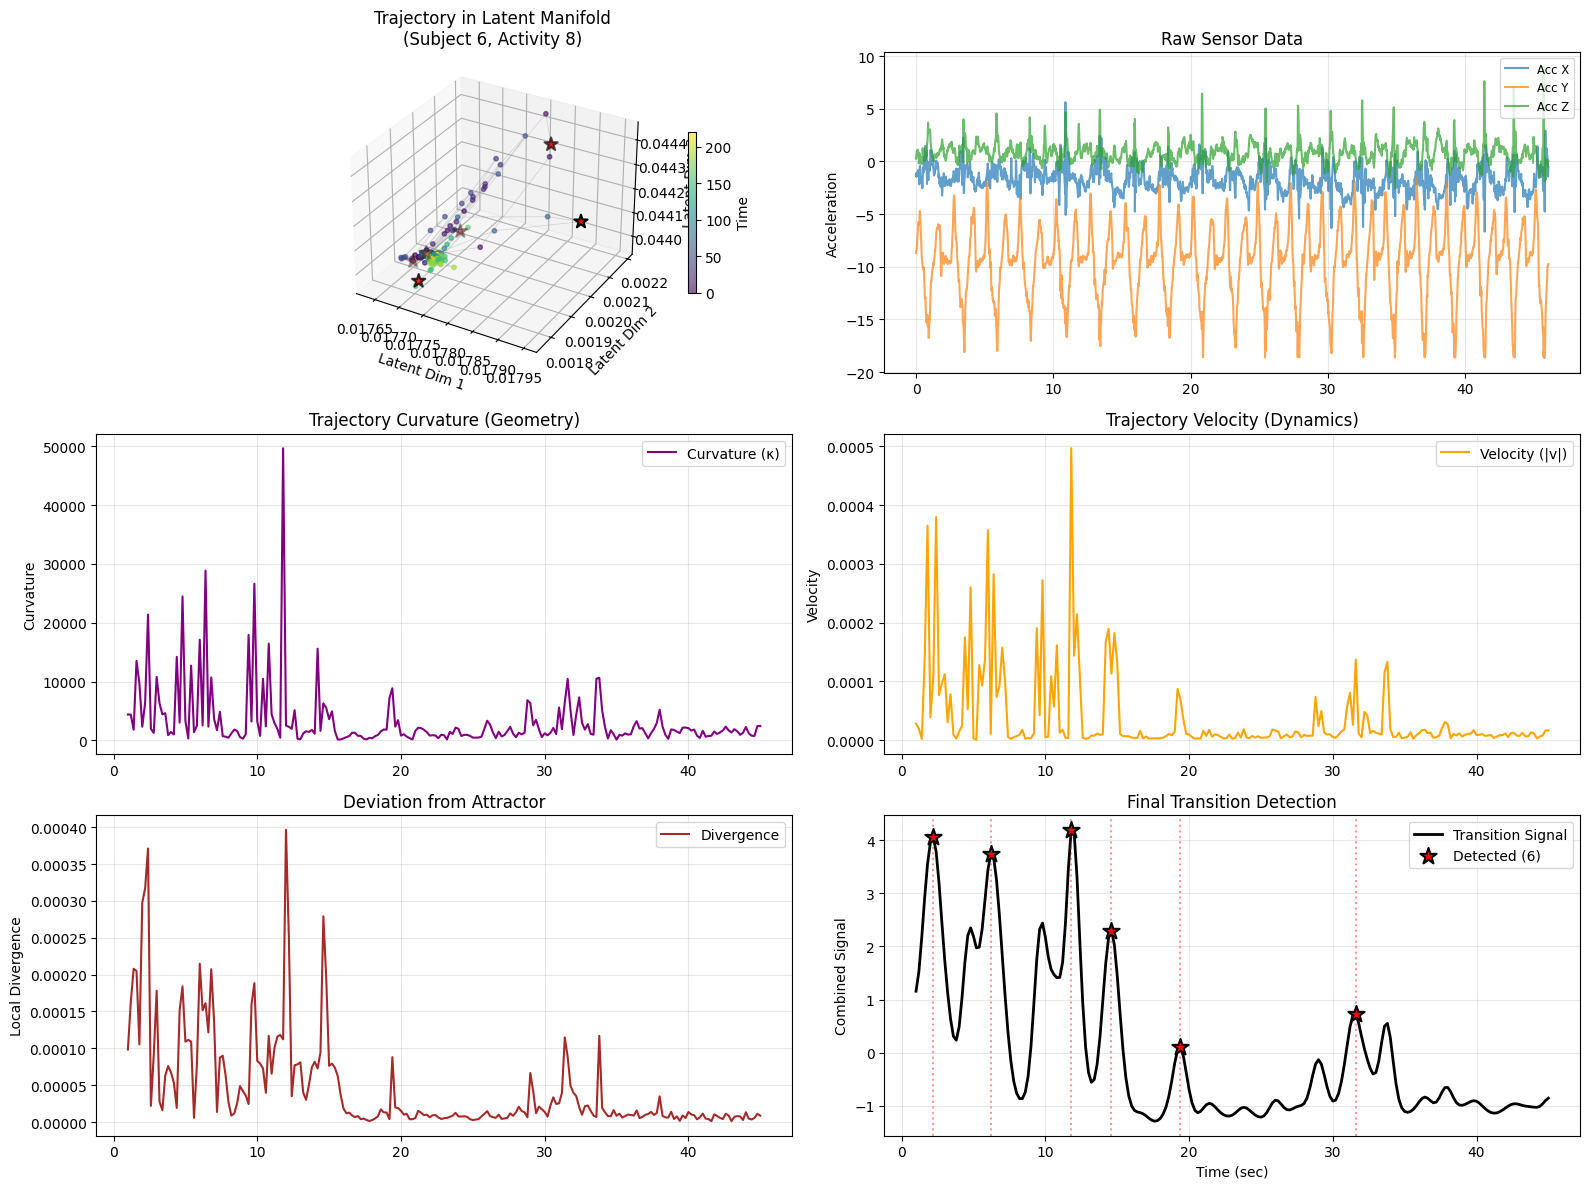

Subject 7 | Activity 8 | Detected Transitions: 10


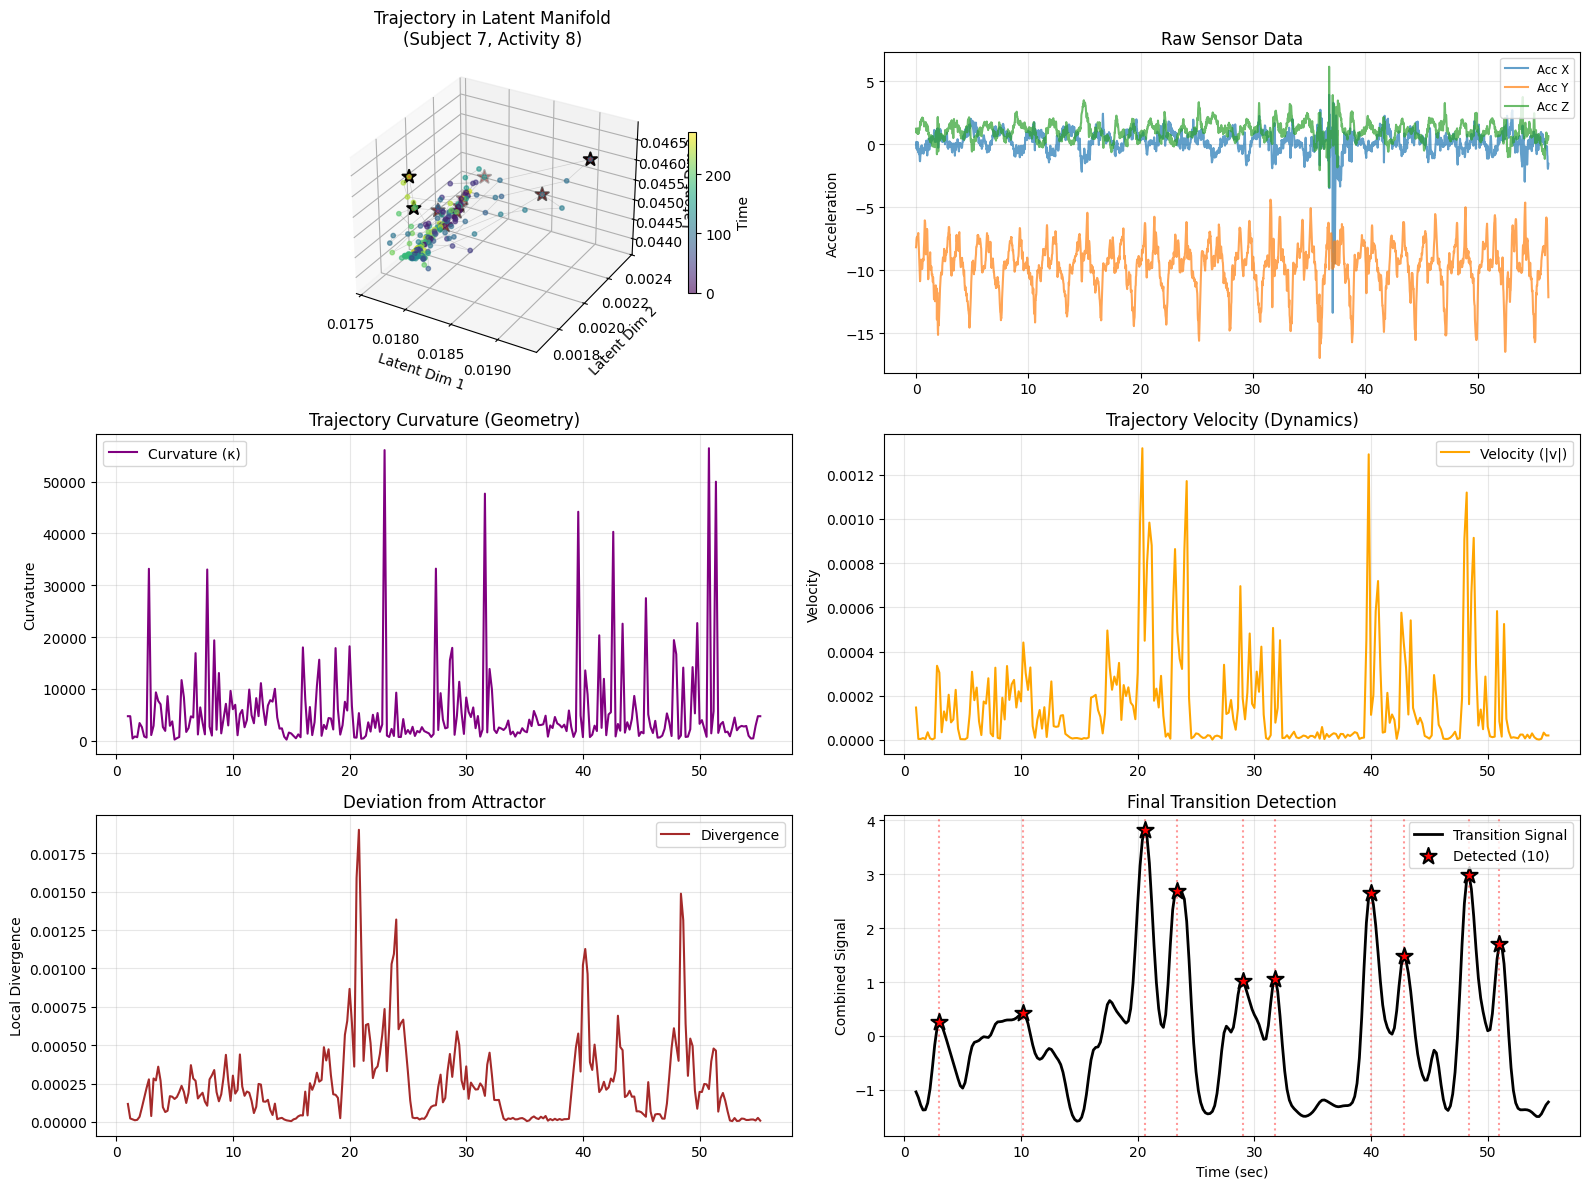

Subject 8 | Activity 8 | Detected Transitions: 12


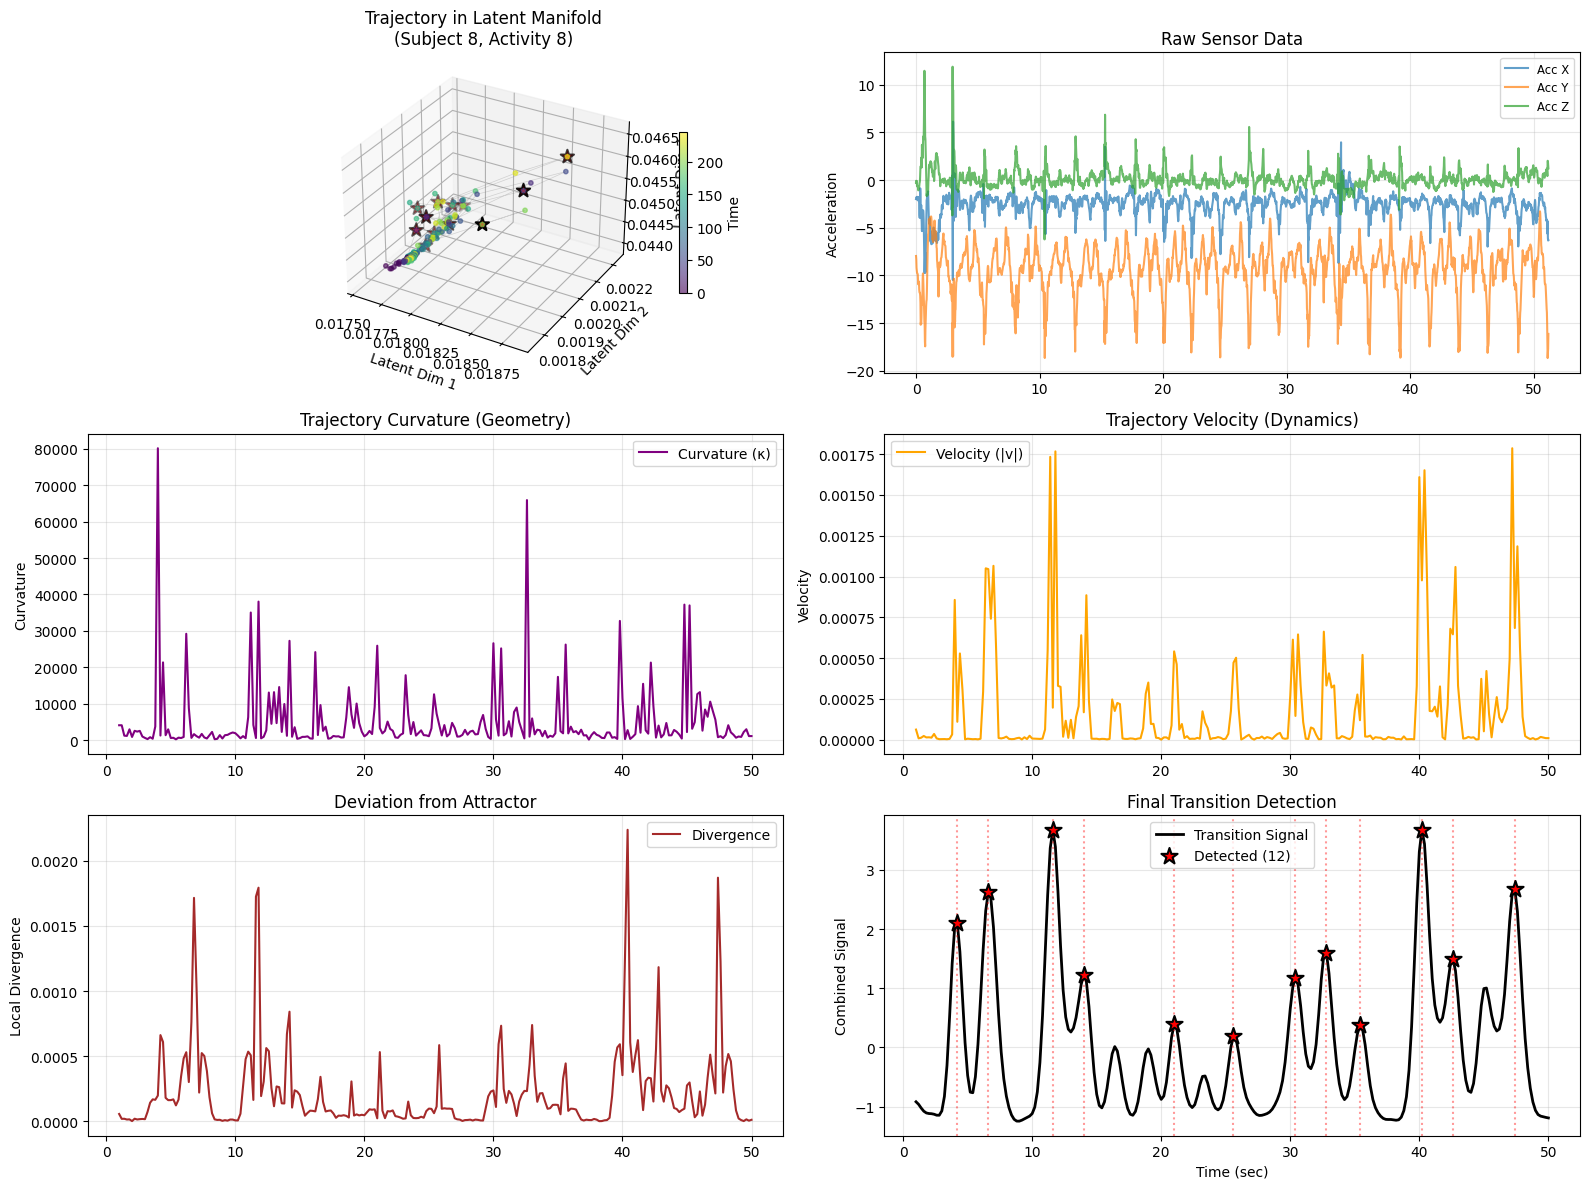

Subject 9 | Activity 8 | Detected Transitions: 10


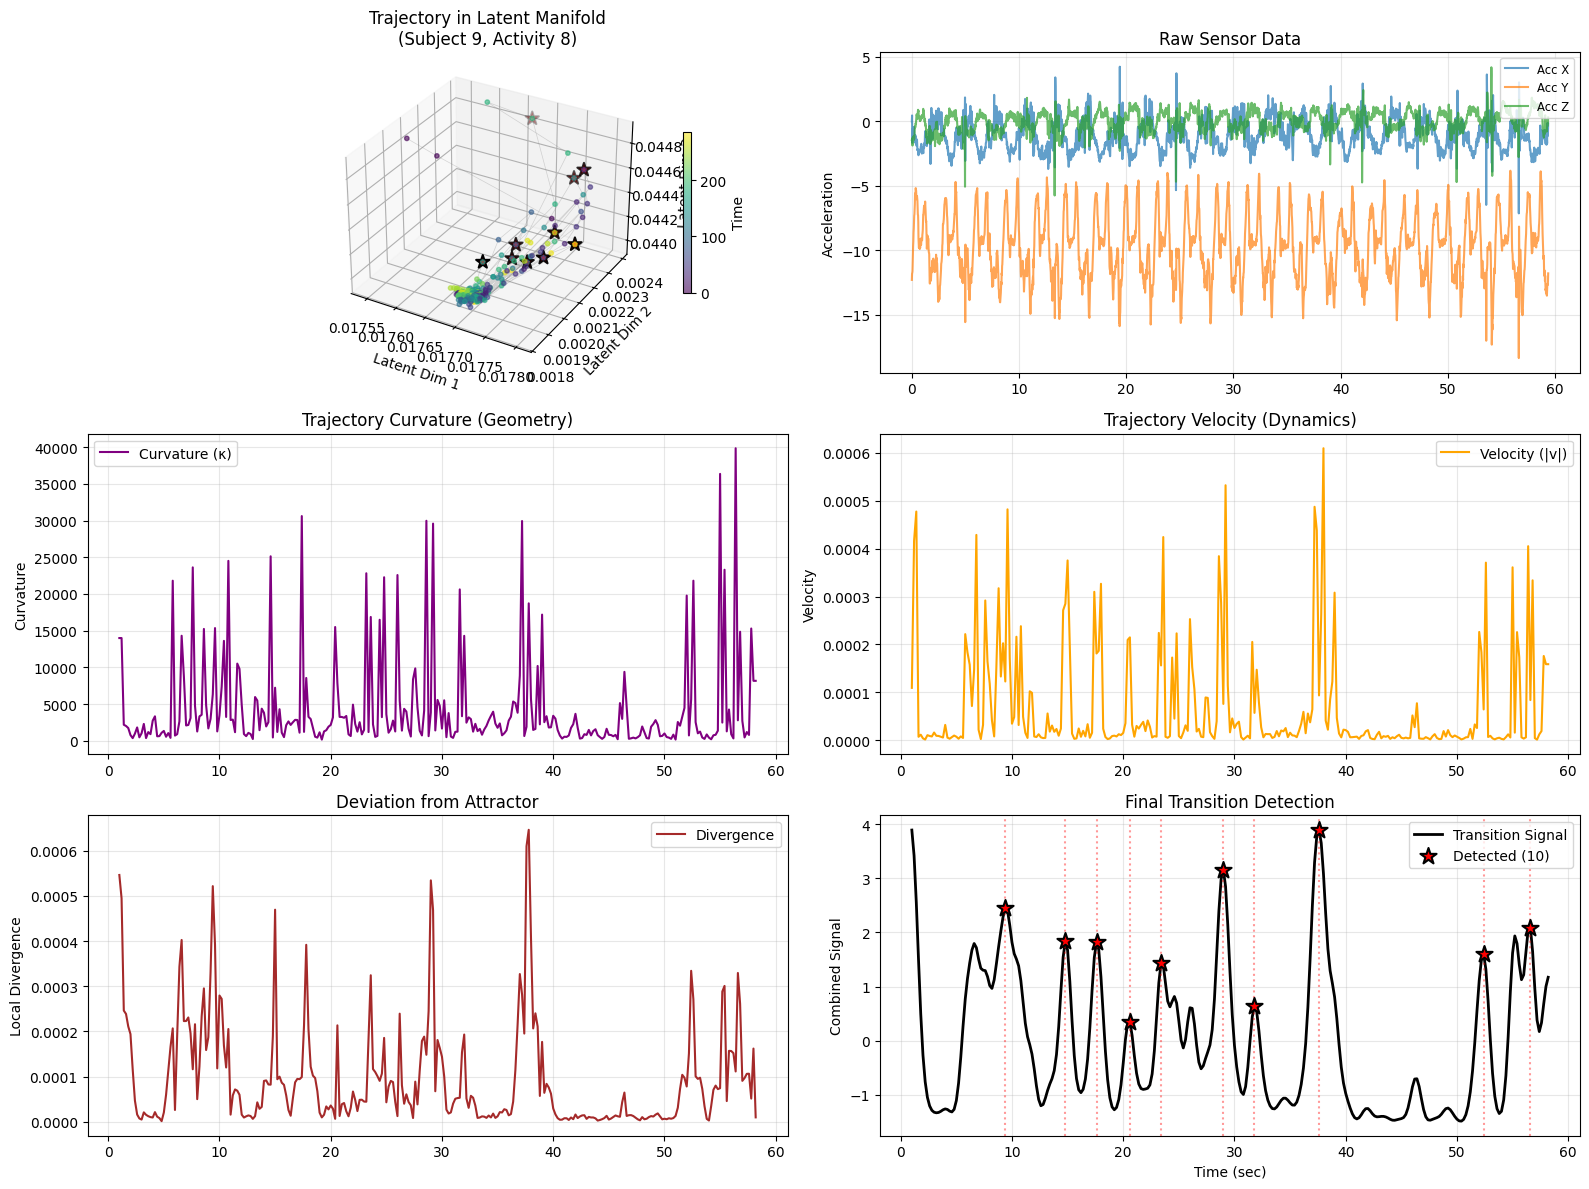

Subject 10 | Activity 8 | Detected Transitions: 9


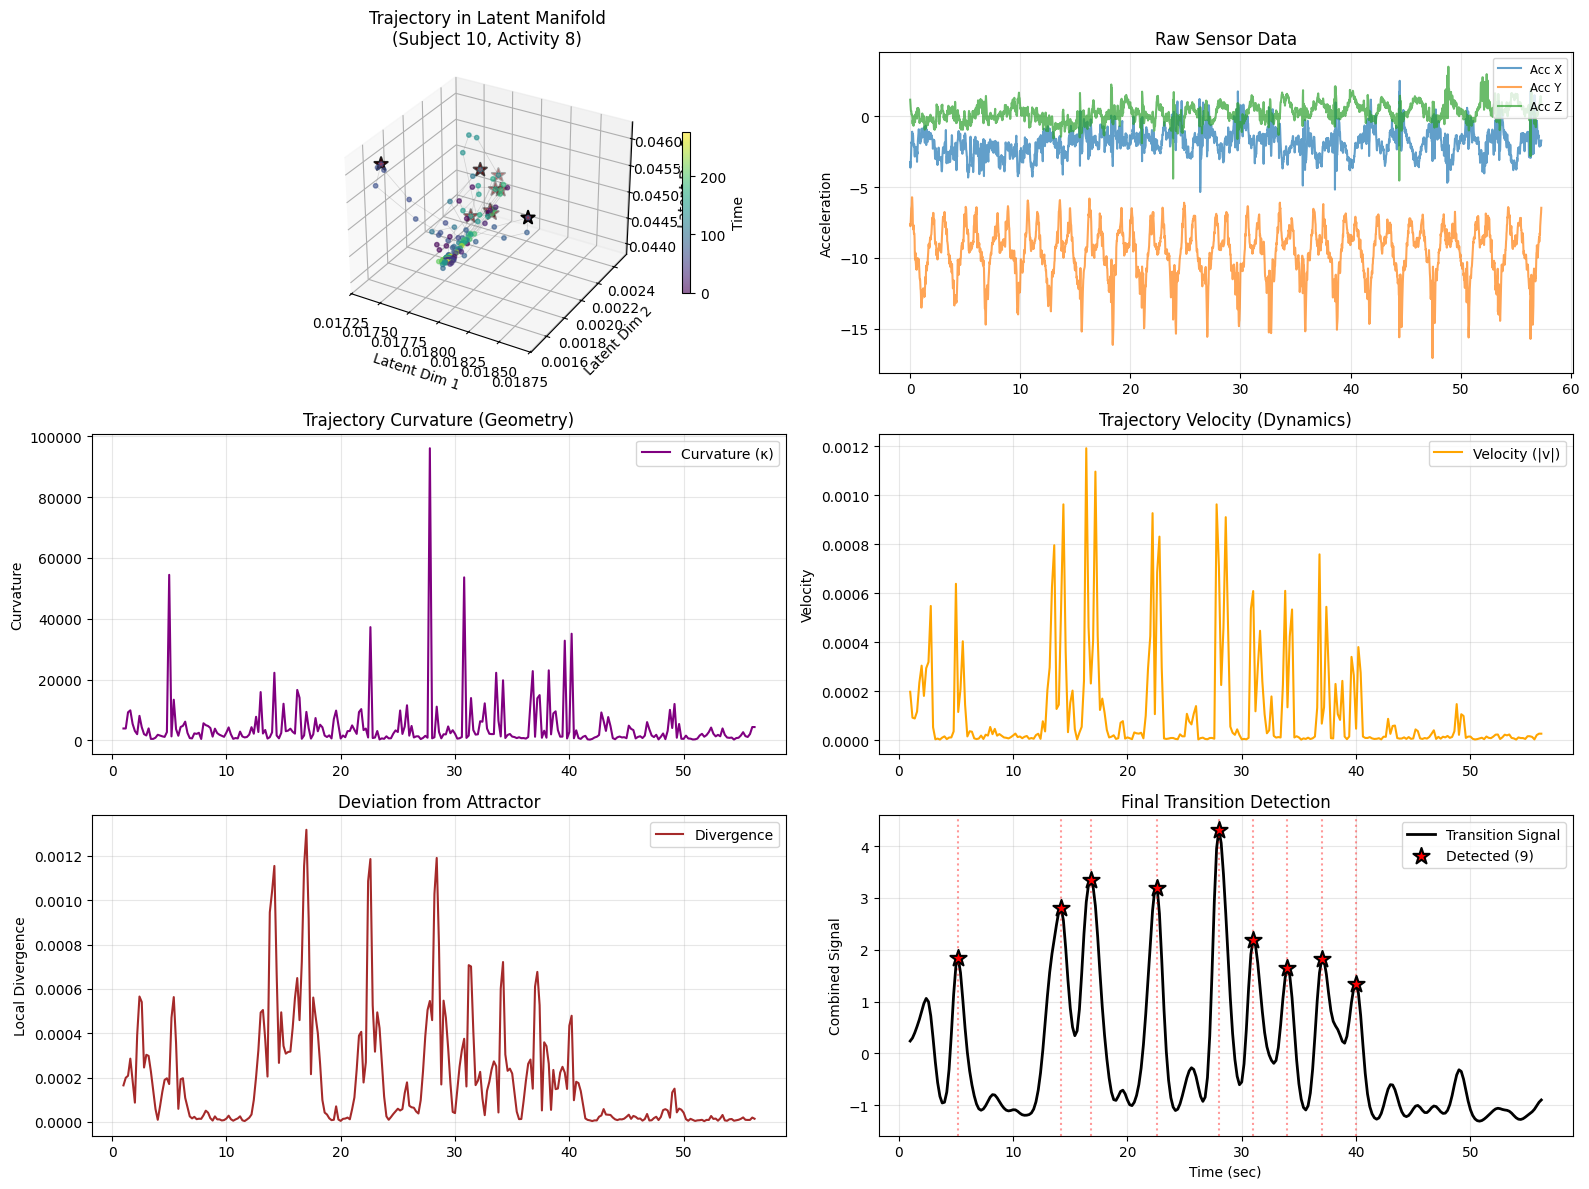

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ==========================================
# 0. Configuration
# ==========================================
CONFIG = {
    'window_size': 100,
    'stride': 50,
    'batch_size': 64,
    'lr': 1e-3,
    'epochs': 30,
    'latent_dim': 3,
    'hidden_dim': 128,
    'lambda_recon': 1.0,
    'lambda_smooth': 0.1,
    'fs': 50,
    'seed': 42,
    'target_activities': [8],
    'train_subjects': ['subject1', 'subject2'],
    'test_subjects': [f'subject{i}' for i in range(1, 11)], # 1~10 전체
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(CONFIG['seed'])

# ==========================================
# 1. Manifold Encoder (기존과 동일)
# ==========================================
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch=6, hidden_dim=128, latent_dim=3, win_size=100):
        super().__init__()
        self.conv1 = nn.Conv1d(input_ch, hidden_dim, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc_latent = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.fc_decode = nn.Linear(latent_dim, hidden_dim * 25)
        self.deconv1 = nn.ConvTranspose1d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose1d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.final = nn.Conv1d(hidden_dim, input_ch, kernel_size=3, padding=1)

    def forward(self, x):
        h = F.relu(self.conv2(F.relu(self.conv1(x))))
        z = self.fc_latent(self.pool(h).squeeze(-1))

        h_dec = self.fc_decode(z).view(-1, 128, 25)
        h_dec = F.relu(self.deconv2(F.relu(self.deconv1(h_dec))))
        return z, self.final(h_dec)

# ==========================================
# 2. Helper Functions (Geometry)
# ==========================================
def compute_curvature(trajectory):
    if len(trajectory) < 3: return torch.zeros(1)
    v = trajectory[1:-1] - trajectory[:-2]
    a = (trajectory[2:] - trajectory[1:-1]) - v
    return (torch.norm(a, dim=1) / (torch.norm(v, dim=1)**2 + 1e-8)).squeeze()

def compute_velocity(trajectory):
    if len(trajectory) < 2: return torch.zeros(1)
    return torch.norm(trajectory[1:] - trajectory[:-1], dim=1)

def compute_trajectory_divergence(trajectory, window=5):
    div = []
    for i in range(len(trajectory)):
        s, e = max(0, i-window), min(len(trajectory), i+window+1)
        div.append(torch.norm(trajectory[i] - trajectory[s:e].mean(dim=0)).item())
    return np.array(div)

# ==========================================
# 3. [수정됨] Data Loader for .log files
# ==========================================
class RawSequenceDataset(Dataset):
    def __init__(self, sequences): self.sequences = sequences
    def __len__(self): return len(self.sequences)
    def __getitem__(self, idx): return torch.tensor(self.sequences[idx], dtype=torch.float32).transpose(0, 1)

def load_mhealth_logs(dataset_dir, config):
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"폴더를 찾을 수 없습니다: {dataset_dir}")

    # --- 1. 컬럼명 및 활동 매핑 정의 (사용자 제공) ---
    COLUMN_NAMES = [
        'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
        'ecg_1', 'ecg_2',
        'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
        'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
        'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
        'acc_arm_x', 'acc_arm_y', 'acc_arm_z', # <- 선택된 센서
        'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z', # <- 선택된 센서
        'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
        'activity_id' # <- 레이블
    ]

    ACTIVITY_MAP = {
        0: 'Other (Transient)', 1: 'Standing', 2: 'Sitting', 3: 'Lying',
        4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends',
        7: 'Knees bending', 8: 'Cycling', 9: 'Jogging',
        10: 'Running', 11: 'Jumping', 12: 'Push-ups'
    }

    # --- 2. 모델 입력용 센서 정의 (acc_arm + gyro_arm) ---
    target_feature_map = {
        'acc_arm_x': 'alx', 'acc_arm_y': 'aly', 'acc_arm_z': 'alz',
        'gyro_arm_x': 'glx', 'gyro_arm_y': 'gly', 'gyro_arm_z': 'glz'
    }
    feature_cols = ['alx', 'aly', 'alz', 'glx', 'gly', 'glz']
    df_list = []

    print(f"[Data Load] '{dataset_dir}' 폴더에서 데이터 로딩 중 (Sensor: Arm Acc/Gyro)...")

    for i in range(1, 11):
        filename = f"mHealth_subject{i}.log"
        file_path = os.path.join(dataset_dir, filename)

        if not os.path.exists(file_path):
            continue

        try:
            # 로그 파일 읽기 (sep=r'\s+'로 SyntaxWarning 방지)
            temp_df = pd.read_csv(file_path, header=None, sep=r'\s+')

            if temp_df.shape[1] >= len(COLUMN_NAMES):
                temp_df.columns = COLUMN_NAMES[:temp_df.shape[1]]

            # --- 3. 필요한 컬럼 선택 및 이름 변경 ---
            selected_cols = list(target_feature_map.keys()) + ['activity_id']

            if all(col in temp_df.columns for col in selected_cols):
                temp_df = temp_df.rename(columns=target_feature_map)
                temp_df['subject_id'] = i

                # 라벨 컬럼명을 'Activity'로 통일하고 'activity_id'에서 가져옴
                temp_df.rename(columns={'activity_id': 'Activity'}, inplace=True)

                 # Activity ID 0 ('Other') 제외
                temp_df = temp_df[temp_df['Activity'] != 0].copy()

                final_cols = feature_cols + ['Activity', 'subject_id']
                temp_df = temp_df[final_cols]

                df_list.append(temp_df)
                print(f"  -> Loaded {filename}: {len(temp_df)} samples (ID 0 excluded)")
            else:
                print(f"  [Warning] {filename}에 필요한 Arm 센서 데이터가 없습니다.")

        except Exception as e:
            print(f"  [Error] {filename} 로딩 실패: {e}")

    if not df_list:
        raise ValueError("데이터 로드 실패")

    df_all = pd.concat(df_list, ignore_index=True)

    train_ids = [int(str(s).replace('subject', '')) for s in config['train_subjects']]
    test_ids = [int(str(s).replace('subject', '')) for s in config['test_subjects']]

    df_train = df_all[df_all['subject_id'].isin(train_ids)].copy()
    df_test = df_all[df_all['subject_id'].isin(test_ids)].copy()

    # 활동 코드 확인 (디버깅용)
    print("\n--- NEW ACTIVITY MAP ---")
    for key, value in ACTIVITY_MAP.items():
        if key != 0:
            print(f"Activity {key}: {value}")
    print("------------------------")

    return df_train, df_test, feature_cols

def create_windows(df, features, config):
    windows = []
    if len(df) == 0: return np.array([])

    for sub in df['subject_id'].unique():
        sub_df = df[df['subject_id'] == sub][features].values
        # 결측치 처리 (혹시 모를 NaNs)
        sub_df = np.nan_to_num(sub_df)

        if len(sub_df) < config['window_size']: continue

        mean = np.mean(sub_df, axis=0)
        std = np.std(sub_df, axis=0) + 1e-6
        norm_data = (sub_df - mean) / std

        for i in range(0, len(norm_data) - config['window_size'], config['stride']):
            windows.append(norm_data[i : i + config['window_size']])

    return np.array(windows)

# ==========================================
# 4. Training & Detection (기존 로직 유지)
# ==========================================
def train(model, loader, config):
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    model.train()

    print("\n[Training Manifold Encoder]")
    for epoch in range(config['epochs']):
        total_loss = 0
        total_recon = 0
        total_smooth = 0

        for x in loader:
            x = x.to(DEVICE)
            z, recon = model(x)

            # Reconstruction loss
            loss_recon = F.mse_loss(recon, x)

            # Trajectory smoothness regularization
            # Encourage smooth manifold structure
            if len(z) > 1:
                z_diff = z[1:] - z[:-1]
                loss_smooth = torch.mean(torch.norm(z_diff, dim=1))
            else:
                loss_smooth = torch.tensor(0.0)

            loss = config['lambda_recon'] * loss_recon + \
                   config['lambda_smooth'] * loss_smooth

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += loss_recon.item()
            total_smooth += loss_smooth.item()

        if (epoch+1) % 5 == 0:
            avg_loss = total_loss / len(loader)
            avg_recon = total_recon / len(loader)
            avg_smooth = total_smooth / len(loader)
            print(f"Epoch {epoch+1}/{config['epochs']} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | Smooth: {avg_smooth:.4f}")

    return model

def detect_transitions_via_manifold(model, df_test, features, config):
    """
    Main detection pipeline using manifold geometry
    """
    model.eval()

    for sub in df_test['subject_id'].unique():
        sub_data = df_test[df_test['subject_id'] == sub]

        for act in config['target_activities']:
            act_data = sub_data[sub_data['Activity'] == act]

            if len(act_data) < config['window_size'] * 3:
                continue

            # Prepare data
            raw_vals = act_data[features].values
            mean = np.mean(raw_vals, axis=0)
            std = np.std(raw_vals, axis=0) + 1e-6
            norm_vals = (raw_vals - mean) / std

            # Extract trajectory in latent space
            latent_points = []
            step = 10

            with torch.no_grad():
                for i in range(0, len(norm_vals) - config['window_size'], step):
                    segment = norm_vals[i : i + config['window_size']]
                    x_in = torch.tensor(segment, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(DEVICE)
                    z, _ = model(x_in)
                    latent_points.append(z.cpu().numpy())

            latent_points = np.concatenate(latent_points, axis=0)  # (N, latent_dim)
            latent_tensor = torch.tensor(latent_points, dtype=torch.float32)

            # Compute geometric features
            curvature = compute_curvature(latent_tensor).numpy()
            velocity = compute_velocity(latent_tensor).numpy()
            divergence = compute_trajectory_divergence(latent_tensor, window=5)

            # Pad curvature to match length
            curvature_padded = np.pad(curvature, (1, 1), mode='edge')
            velocity_padded = np.pad(velocity, (0, 1), mode='edge')

            # Combined transition signal
            # High curvature + high velocity + high divergence = transition
            curvature_norm = (curvature_padded - np.mean(curvature_padded)) / (np.std(curvature_padded) + 1e-6)
            velocity_norm = (velocity_padded - np.mean(velocity_padded)) / (np.std(velocity_padded) + 1e-6)
            divergence_norm = (divergence - np.mean(divergence)) / (np.std(divergence) + 1e-6)

            transition_signal = curvature_norm + velocity_norm + 0.5 * divergence_norm

            # Smoothing
            smoothed_signal = gaussian_filter1d(transition_signal, sigma=2.0)

            # Peak detection
            prominence = 0.8 * np.std(smoothed_signal)
            height_thresh = np.percentile(smoothed_signal, 60)
            min_dist = int((0.8 * config['fs']) / step)

            peaks, properties = find_peaks(smoothed_signal,
                                          height=height_thresh,
                                          prominence=prominence,
                                          distance=max(min_dist, 1))

            act_name_map = {
                0: 'Other', 1: 'Standing', 2: 'Sitting', 3: 'Lying',
                4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends',
                7: 'Knees bending', 8: 'Cycling', 9: 'Jogging',
                10: 'Running', 11: 'Jumping', 12: 'Push-ups'
            }
            act_name = act_name_map.get(act, f"ID {act}")

            print(f"Subject {sub} | Activity {act} | Detected Transitions: {len(peaks)}")

            # Visualization
            if len(peaks) > 0:
                visualize_manifold_analysis(
                    raw_vals, latent_points,
                    curvature_padded, velocity_padded, divergence,
                    smoothed_signal, peaks,
                    config, step, sub, act
                )

def visualize_manifold_analysis(raw_vals, latent_points, curvature, velocity,
                                divergence, transition_signal, peaks,
                                config, step, sub, act):
    """
    Comprehensive visualization of manifold-based transition detection
    """
    time_axis_raw = np.arange(len(raw_vals)) / config['fs']
    time_axis_latent = (np.arange(len(latent_points)) * step + config['window_size']//2) / config['fs']

    fig = plt.figure(figsize=(16, 12))

    # 1. 3D Trajectory in Latent Space
    ax1 = fig.add_subplot(3, 2, 1, projection='3d')
    if latent_points.shape[1] >= 3:
        scatter = ax1.scatter(latent_points[:, 0], latent_points[:, 1], latent_points[:, 2],
                            c=np.arange(len(latent_points)), cmap='viridis', s=10, alpha=0.6)
        ax1.plot(latent_points[:, 0], latent_points[:, 1], latent_points[:, 2],
                'gray', alpha=0.3, linewidth=0.5)

        # Highlight transition points
        if len(peaks) > 0:
            ax1.scatter(latent_points[peaks, 0], latent_points[peaks, 1], latent_points[peaks, 2],
                       c='red', s=100, marker='*', edgecolors='black', linewidths=1.5)

        ax1.set_xlabel('Latent Dim 1')
        ax1.set_ylabel('Latent Dim 2')
        ax1.set_zlabel('Latent Dim 3')
        ax1.set_title(f'Trajectory in Latent Manifold\n(Subject {sub}, Activity {act})')
        plt.colorbar(scatter, ax=ax1, label='Time', shrink=0.5)

    # 2. Raw Accelerometer
    ax2 = fig.add_subplot(3, 2, 2)
    ax2.plot(time_axis_raw, raw_vals[:, 0], label='Acc X', alpha=0.7)
    ax2.plot(time_axis_raw, raw_vals[:, 1], label='Acc Y', alpha=0.7)
    ax2.plot(time_axis_raw, raw_vals[:, 2], label='Acc Z', alpha=0.7)
    ax2.set_ylabel('Acceleration')
    ax2.set_title('Raw Sensor Data')
    ax2.legend(loc='upper right', fontsize='small')
    ax2.grid(True, alpha=0.3)

    # 3. Curvature
    ax3 = fig.add_subplot(3, 2, 3)
    ax3.plot(time_axis_latent, curvature, color='purple', linewidth=1.5, label='Curvature (κ)')
    ax3.set_ylabel('Curvature')
    ax3.set_title('Trajectory Curvature (Geometry)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Velocity
    ax4 = fig.add_subplot(3, 2, 4)
    ax4.plot(time_axis_latent, velocity, color='orange', linewidth=1.5, label='Velocity (|v|)')
    ax4.set_ylabel('Velocity')
    ax4.set_title('Trajectory Velocity (Dynamics)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Divergence
    ax5 = fig.add_subplot(3, 2, 5)
    ax5.plot(time_axis_latent, divergence, color='brown', linewidth=1.5, label='Divergence')
    ax5.set_ylabel('Local Divergence')
    ax5.set_title('Deviation from Attractor')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Combined Transition Signal
    ax6 = fig.add_subplot(3, 2, 6)
    ax6.plot(time_axis_latent, transition_signal, color='black', linewidth=2, label='Transition Signal')
    ax6.scatter(time_axis_latent[peaks], transition_signal[peaks],
               c='red', s=150, marker='*', zorder=5, label=f'Detected ({len(peaks)})',
               edgecolors='black', linewidths=1.5)

    for p_t in time_axis_latent[peaks]:
        ax6.axvline(x=p_t, color='red', linestyle=':', alpha=0.4)

    ax6.set_xlabel('Time (sec)')
    ax6.set_ylabel('Combined Signal')
    ax6.set_title('Final Transition Detection')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# 5. Main Execution
# ==========================================
def main():
    # [중요] 여기에 MHEALTHDATASET 폴더 경로를 넣으세요
    # 예: '/content/MHEALTHDATASET' 또는 로컬 경로
    dataset_folder = '/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET'

    print("="*60)
    print("Manifold Analysis (Loading from .log files)")
    print("="*60)

    try:
        # 데이터 로딩 함수 교체됨
        df_train, df_test, feat_cols = load_mhealth_logs(dataset_folder, CONFIG)
    except Exception as e:
        print(f"오류 발생: {e}")
        return

    # 학습
    train_wins = create_windows(df_train, feat_cols, CONFIG)
    if len(train_wins) == 0:
        print("학습 데이터가 없습니다.")
        return

    model = ManifoldEncoder(win_size=CONFIG['window_size']).to(DEVICE)

    train_loader = DataLoader(RawSequenceDataset(train_wins), batch_size=CONFIG['batch_size'], shuffle=True)
    model = train(model, train_loader, CONFIG)

    # 평가
    detect_transitions_via_manifold(model, df_test, feat_cols, CONFIG)

if __name__ == '__main__':
    main()